# Template Matching

In [1]:
import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import math

Importing the first frame

In [2]:
# --- Paths ---
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / "recording_2" / "Recording_2.mp4")
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "lane_lines" / "definitive_lines_2.csv")

# --- Load frame ---
frame_index = 20
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Failed to read the frame")

height, width = frame.shape[:2]
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)
frame_data = df.iloc[frame_index]

Importing the template

In [3]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

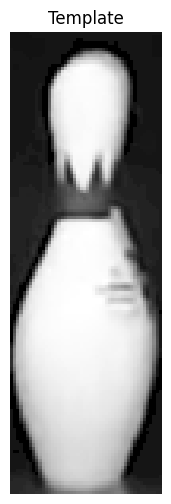

In [4]:
template = cv2.imread('intermediate_data/Template_pin_2.png', 0) # 0 for the grayscale image

h, w = template.shape

showImage(template, "Template")

Changing the first frame in order to delete the parts that are off the main lane

In [5]:
# --- Helper functions ---
def get_extended_line(x1, y1, x2, y2, img_width, img_height):
    """Extend a line to the image boundaries."""
    if x1 == x2:
        return (x1, 0), (x2, img_height)
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    points = []

    y_left = int(m * 0 + b)
    y_right = int(m * img_width + b)
    if 0 <= y_left <= img_height:
        points.append((0, y_left))
    if 0 <= y_right <= img_height:
        points.append((img_width, y_right))

    if m != 0:
        x_top = int((0 - b) / m)
        x_bottom = int((img_height - b) / m)
        if 0 <= x_top <= img_width:
            points.append((x_top, 0))
        if 0 <= x_bottom <= img_width:
            points.append((x_bottom, img_height))

    return points[:2] if len(points) >= 2 else ((x1, y1), (x2, y2))

In [6]:
def get_intersection(p1, p2, p3, p4):
    """Find the intersection point of two lines."""
    xdiff = (p1[0] - p2[0], p3[0] - p4[0])
    ydiff = (p1[1] - p2[1], p3[1] - p4[1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(p1, p2), det(p3, p4))
    x = int(det(d, xdiff) / div)
    y = int(det(d, ydiff) / div)
    return x, y

In [7]:
# --- Extract line endpoints ---
hx1, hy1, hx2, hy2 = map(int, [frame_data['hx1'], frame_data['hy1'], frame_data['hx2'], frame_data['hy2']])
lx1, ly1, lx2, ly2 = map(int, [frame_data['lx1'], frame_data['ly1'], frame_data['lx2'], frame_data['ly2']])
rx1, ry1, rx2, ry2 = map(int, [frame_data['rx1'], frame_data['ry1'], frame_data['rx2'], frame_data['ry2']])

# --- Get extended lines ---
h_pt1, h_pt2 = get_extended_line(hx1, hy1, hx2, hy2, width, height)
l_pt1, l_pt2 = get_extended_line(lx1, ly1, lx2, ly2, width, height)
r_pt1, r_pt2 = get_extended_line(rx1, ry1, rx2, ry2, width, height)

# --- Get triangle intersection points ---
int1 = get_intersection(h_pt1, h_pt2, l_pt1, l_pt2)
int2 = get_intersection(h_pt1, h_pt2, r_pt1, r_pt2)
int3 = get_intersection(l_pt1, l_pt2, r_pt1, r_pt2)

if None in [int1, int2, int3]:
    raise ValueError("Could not find all three triangle points")

triangle = np.array([int1, int2, int3])

# --- Create mask and apply it ---
mask = np.zeros((height, width), dtype=np.uint8)
cv2.drawContours(mask, [triangle], 0, 255, -1)

masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

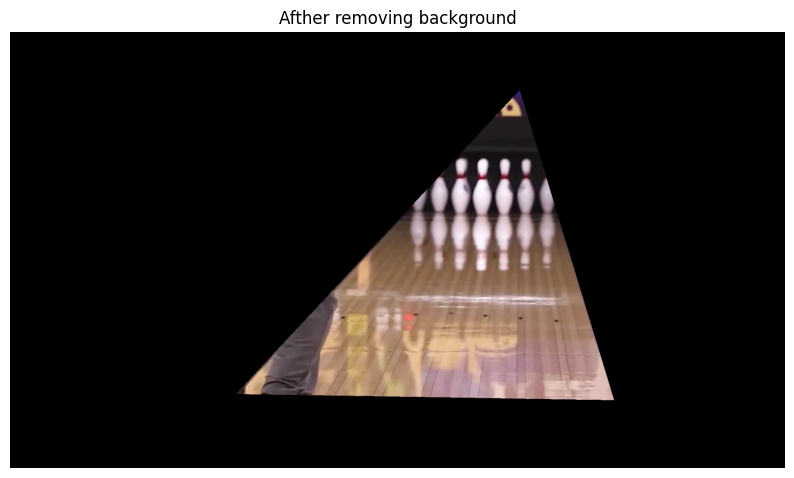

In [8]:
showImage(masked_frame, "Afther removing background")

Now I want to resize the template in the best way possible

In [9]:
# Compute Euclidean distance between int1 and int2
distance = math.hypot(int2[0] - int1[0], int2[1] - int1[1])
print(f"Distance between int1 and int2: {distance:.2f} pixels")

real_length_px = 936.1  # in pixels
real_length_cm = 1066   # real-world equivalent

new_h = int((h * distance) / (real_length_px))
new_w = int((w * distance) / (real_length_px))

fx = new_w/w
fy = new_h/h

template = cv2.resize(template, (0, 0), fx=fx, fy=fy)

print("Original template size:", w, h)
print("Scaling factors -> fx:", fx, "fy:", fy)
print("New template size:", new_w, new_h)

Distance between int1 and int2: 936.12 pixels
Original template size: 48 146
Scaling factors -> fx: 1.0 fy: 1.0
New template size: 48 146


Applying the Template Matching methods

In [10]:
masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)

# Methods for doing Template Matching
methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]

# I try all methods to see which is the best for my case
for method in methods:
    img = masked_frame.copy()

    result = cv2.matchTemplate(img, template, method) # This performs Convolution, the output will be (Width - w + 1, Height - h + 1)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result) # This returns min, max values, min, max locations

    print(min_loc, max_loc)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]: # Here we want the minimum locations
        location = min_loc
    else:
        location = max_loc
    
    bottom_right = (location[0] + new_w, location[1] + new_h)
    cv2.rectangle(img, location, bottom_right, 255, 8)
    cv2.imshow('Match', img)
    cv2.waitKey(0) # Press any key to switch the image between different methods used
    cv2.destroyAllWindows()


(1173, 362) (1146, 306)
(1173, 456) (1146, 307)
(1378, 348) (1145, 395)
(513, 787) (1146, 307)
(1146, 307) (1473, 852)
(1146, 307) (0, 0)
